In [1]:
import numpy as np
from matplotlib.pyplot import *
from pickle import dump,load,HIGHEST_PROTOCOL
from os import chdir

In [2]:
def load_pkl(output_path,name):
    with open(output_path + name + '.pkl', 'rb') as f:
        return load(f)
    
module_path = 'C:\\...\\' #put the path of the TW modules here
data_path = 'C:\\...\\' #put the path where you put the data here
chdir(module_path)

In [3]:
from make_wavelet import *
from TW_analysis_complex_valued_unit_length_phase import *
from decompose_into_pure_traveling_wave import *

In [4]:
#in this data the first two bases are wavenumber=1; in EEG generally the first three are wavenumber=1
nBases = 2
N_cycles = 2
tdel = 2.0
frequency = 9.2
minf = 9.2 #if you analyse multiple frequencies, put the lowest frequency here
contact_xyz = load_pkl(data_path,'xyz_coordinates')

In [5]:
data1_cts = load_pkl(data_path,'avref_timeseries')
power_cts,phi1_cts = wavelet(data1_cts,N_cycles,frequency,tdel,minf)
print(phi1_cts.shape)
data2_cts = load_pkl(data_path,'avref_timeseries_stim')
power_cts,phi2_cts = wavelet(data2_cts,N_cycles,frequency,tdel,minf)
print(phi2_cts.shape)
phi_cts = np.concatenate((phi1_cts,phi2_cts),axis=0)

(26, 1442, 64)
(32, 1442, 64)


In [6]:
bases_sb,fit_ct,betas_ctb = C_TW_bases_betas(phi_cts,nBases=nBases)
print(bases_sb.shape,fit_ct.shape,betas_ctb.shape)

[9.54089494 7.63834854]
(64, 2) (58, 1442) (58, 1442, 2)


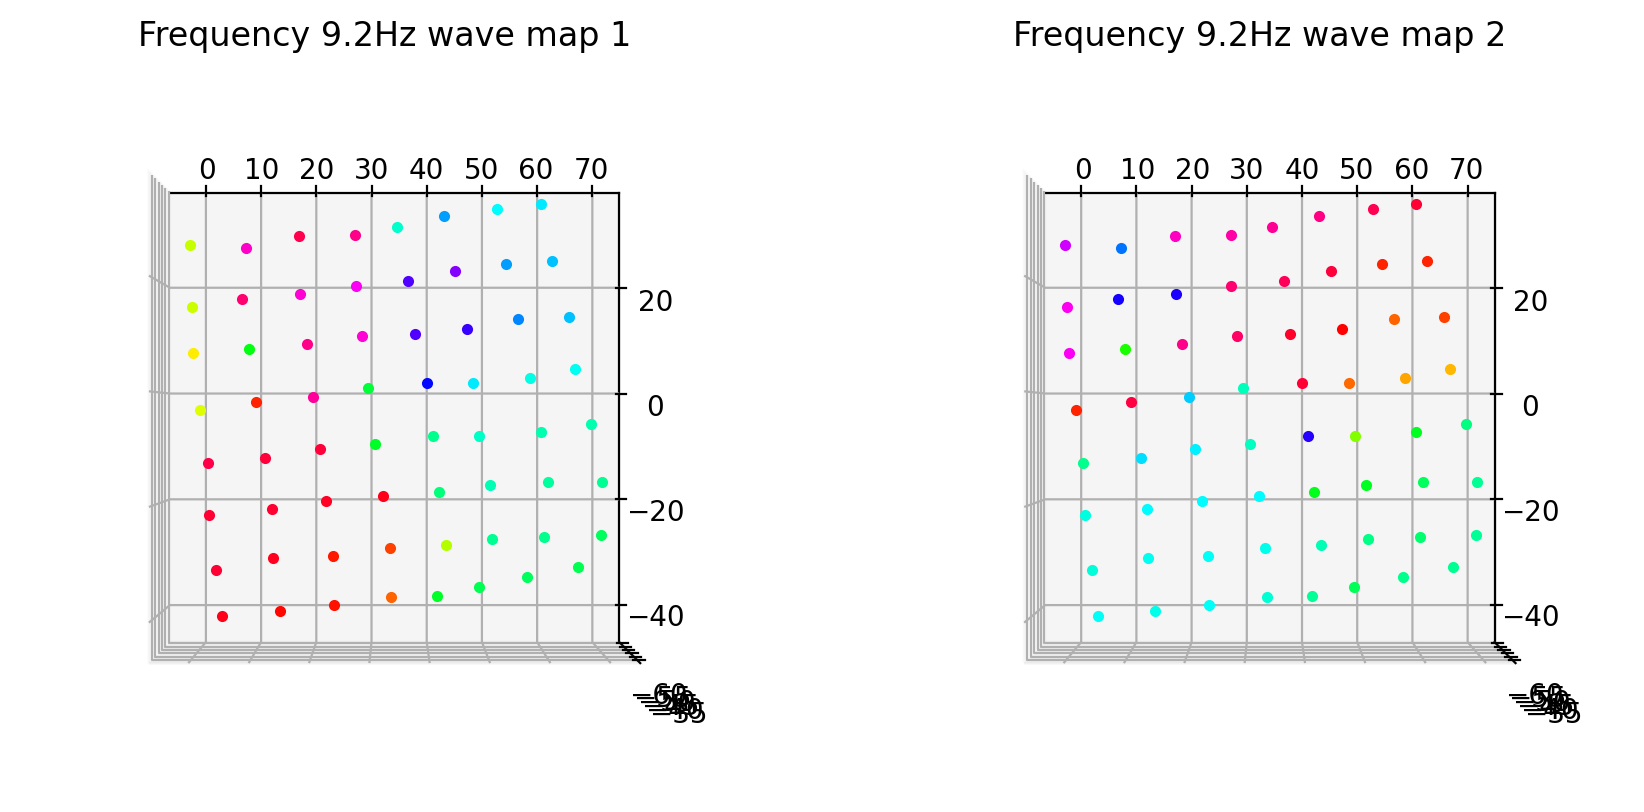

In [7]:
fig = figure(figsize=(nBases*8,8),dpi=200)
axs = []
for b in range(nBases):
    axs += [fig.add_subplot(1,3,b+1,projection='3d')]
    axs[b].view_init(elev=90,azim=-90)
    axs[b].set_title('Frequency %.1fHz wave map %d'%(frequency,b+1))
    for s,xyz in enumerate(contact_xyz):
        color = cm.hsv(np.angle(bases_sb[s,b]) / (2.0*np.pi) + 0.5) #put angles on range 0 to 1
        axs[b].plot(xyz[0],xyz[1],xyz[2],'.',color=color)

In [8]:
#empirical phase bases have a large standing wave component, so we decompose into pure TWs
vel_ct,TWf_cts = decompose_rphi(bases_sb.T[np.newaxis],tdel,frequency)
print('Estimated velocity',vel_ct)

Estimated velocity [[0.32908465 0.35030248]]


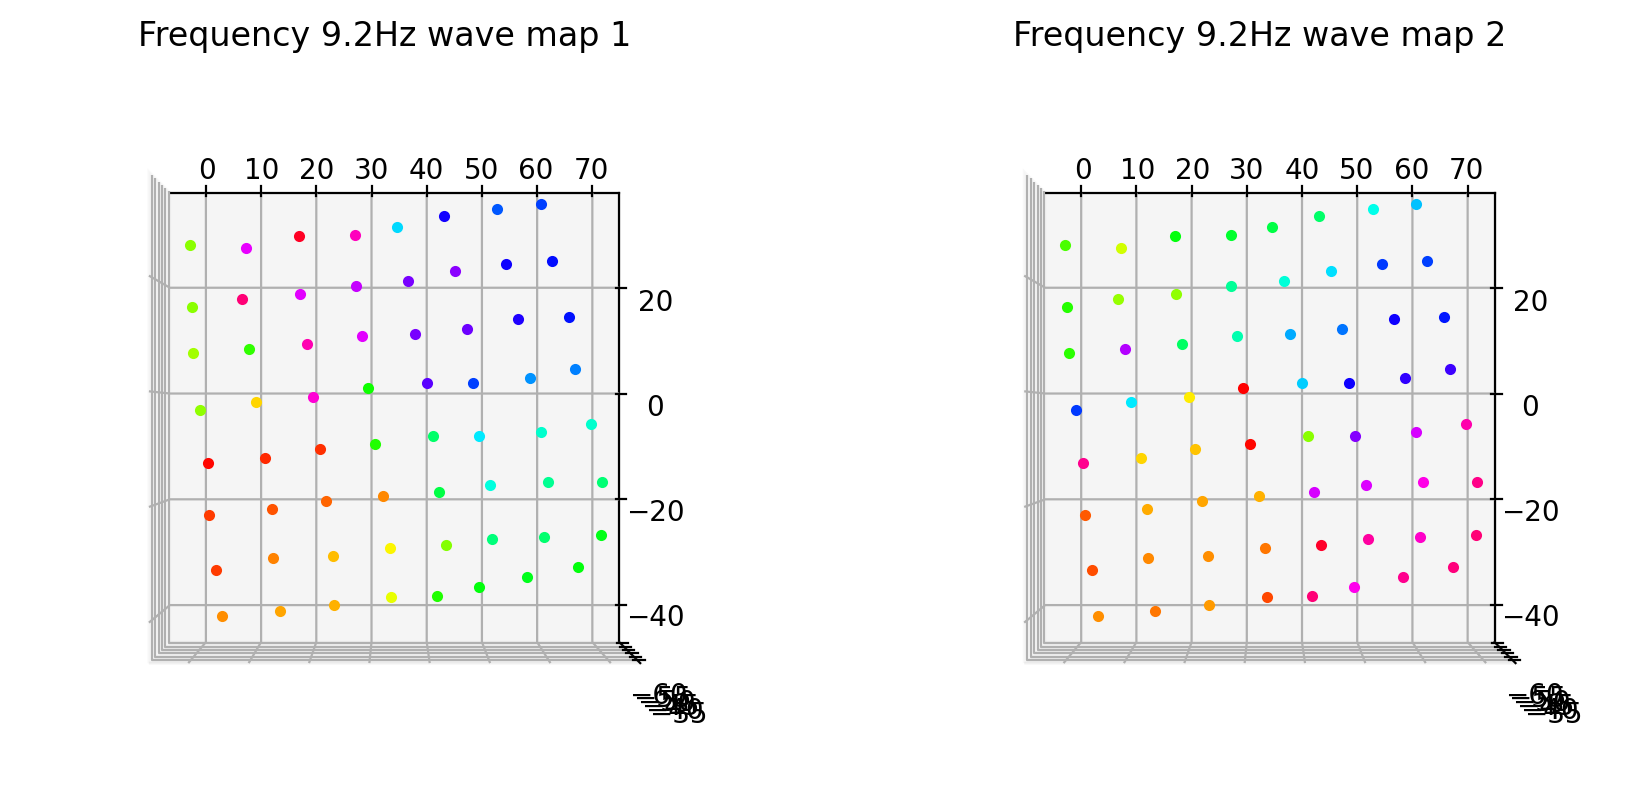

In [9]:
fig = figure(figsize=(nBases*8,8),dpi=200)
axs = []
for b in range(nBases):
    axs += [fig.add_subplot(1,3,b+1,projection='3d')]
    axs[b].view_init(elev=90,azim=-90)
    axs[b].set_title('Frequency %.1fHz wave map %d'%(frequency,b+1))
    for s,xyz in enumerate(contact_xyz):
        color = cm.hsv(np.angle(TWf_cts[0,b,s]) / (2.0*np.pi) + 0.5) #put angles on range 0 to 1
        axs[b].plot(xyz[0],xyz[1],xyz[2],'.',color=color)

In [10]:
#normalized velocity of the pure TW components
vel_ct,TWf_cts = decompose_rphi(TWf_cts,tdel,frequency)
print('Estimated velocity',vel_ct)

Estimated velocity [[1. 1.]]


In [11]:
#make reduced rank version of original data so we are only analyzing components with wavenumber~=1
betas_Cb = betas_ctb.reshape(-1,betas_ctb.shape[2])
model_Cs = (bases_sb@betas_Cb.T).T
print(model_Cs.shape)
model_cts = model_Cs.reshape(phi_cts.shape)

(83636, 64)


In [12]:
#samplewise velocity estimates
vel_ct,TWf_cts = decompose_rphi(model_cts,tdel,frequency)

Text(0, 0.5, 'Normalized velocity (dimensionless units)')

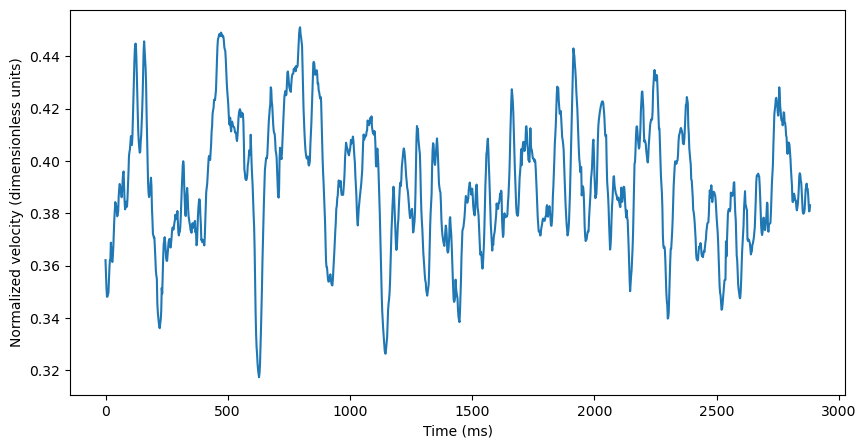

In [13]:
#plot trial-averaged velocity (standing wave = 0, traveling wave = 1)
fig = figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)
time = np.arange(vel_ct.shape[1])*tdel
ax.plot(time,vel_ct.mean(0))
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Normalized velocity (dimensionless units)')